In [1]:
import os
import numpy
import h5py
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
import wendypy
import wendym2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
from scipy.optimize import curve_fit
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= True
save_chain_figures= False
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
import copy
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%aimport wendym2m
%aimport hom2m
%autoreload 1

# Generate one-dimensional self-gravity with an external potential taking into account number/mass density ratio, $X_{nm}$. Then, add a perturber to generate a perturbed disk. 

Here we generate one-dimensional self-gravity and a constant density background, taking into account number/mass density ratio, which is defined with Xnm. We will add a perturbation to a target 1D disk by a vertical impact, similar to a satellite perturbation. The perturbed and unperturbed disks are saved as 'target_disk_unperturbed.h5' and 'target_disk_perturbed.h5'.

## One-dimensional self-gravitating $\mathrm{sech}^2$ disk describing the vertical distribution of density and velocity.

First we generate a self-gravitating isothermal disk (a $\mathrm{sech}^2$ disk) with a constant background. Then, we will perturb the disk with a vertical impact. 

A well-known solution of the one-dimensional N-body system is a $\mathrm{sech}^2$ disk. This is the equilibrium distribution for a disk with an isothermal Gaussian velocity distribution (that is, a velocity distribution that is Gaussian with the same dispersion at all locations). Because the equilibrium distribution can only be a function of the energy $E = \Phi(z)+v^2/2$ and the velocity distribution is required to be Gaussian, $f(v) \propto e^{-v^2/[2\sigma^2]}$, the equilibrium distribution function is by necessity:

$f(z,v) = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-E/\sigma^2} = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-\Phi(z)/\sigma^2-v^2/[2\sigma^2]}\,,$

with density

$\rho(z) = \rho_0\,e^{-\Phi(z)/\sigma^2}\,.$

Plugging this density into the Poisson equation allows us to solve for the potential:

$\frac{\mathrm{d}^2\Phi(z)}{\mathrm{d}z^2} = 4\pi G \rho(z) = 4\pi G \rho_0\,e^{-\Phi(z)/\sigma^2}\,,$

which has the solution

$\Phi(z) = 2\sigma^2 \ln\left(\mathrm{cosh}\left[\frac{z}{2 H}\right]\right)\,,$

with $H^2 = \sigma^2/[8\pi G \rho_0]$, because

$\frac{\mathrm{d}\Phi(z)}{\mathrm{d}z} = \frac{2 \sigma^2}{2 H} \frac{\mathrm{sinh}\left[\frac{z}{2 H}\right]}{\mathrm{cosh}\left[\frac{z}{2 H}\right]} = \frac{2 \sigma^2}{2 H}  \mathrm{tanh}\left[\frac{z}{2 H}\right]$, $\frac{\mathrm{d}^2\Phi(z)}{\mathrm{d}z^2} = \frac{2 \sigma^2}{4 H^2} \mathrm{sech}^2\left[\frac{z}{2 H}\right]$

Alternatively, $H = \sigma^2 / [2\pi G \Sigma]$, where $\Sigma$ is the total surface density. The density is then

$\rho(z) = \rho_0\,\mathrm{sech}^2\left(\frac{z}{2H}\right)\,$

and
 
$\Sigma = \int^{\infty}_{-\infty} \rho_0 \mathrm{sech}^2\left[\frac{z}{2 H}\right] dz = 4 H \rho_0$.

We set $\Sigma=1.0$ and $\sigma=0.5$, and therefore with $2 \pi G=1$ unit, $H=0.25$ and $\rho0=1$. 

For an external potential, we consider that in the solar neighborhood dark matter is an approximately constant density $\rho_{\mathrm{DM}} = $ constant.

This density corresponds to a potential $\Phi_{\mathrm{DM}} = \omega^2 z^2 / 2$, with $\omega = \sqrt{4\pi\,G\,\rho_{\mathrm{DM}}}$.

We set $\rho_{\mathrm{DM}}=1$, i.e. equivalent to the disk mass, and therfore $\omega = 1/\sqrt{2}$. 

We consider that the observed density is number density of stars, but in M2M model, each element's $w$ traces mass. Here, we assume the number and mass denity ratio of $X_{nm}$, and fit it as well.

In [3]:
n_init = 100000
n_init0 = n_init
sigma_true = 1.0 # Velocity dispersion in the disc in 20.5 km/s
totmass_true = 1.0 # Surface density of the disc in 50 Msun/pc^2
zh_true = sigma_true**2./totmass_true  # Where 2\pi G= 1 so units of zh are ~311 pc
tdyn = zh_true/sigma_true
# external potential
omegadm_true = 1.0/numpy.sqrt(2.0)
z_init, vz_init, m_init = wendym2m.sample_sech2(
    sigma_true, totmass_true, n=n_init)
print('zh, tdyn, omega_dm =', zh_true, tdyn, omegadm_true)

zh, tdyn, omega_dm = 1.0 1.0 0.7071067811865475


We will add the background potential adiabatically.

In [4]:
g = wendypy.nbody(z_init, vz_init, m_init, 0.05*tdyn, approx=True, nleap=1)

In [5]:
nt = 700
zt = numpy.empty((n_init, nt+1))
vzt = numpy.empty((n_init, nt+1))
# Et = numpy.empty((nt+1))
zt[:, 0] = z_init
vzt[:, 0] = vz_init
# Et[0] = wendy.energy(z_init, vz_init, m_init)
# increasing omega
nstep_omega = 500
domega = omegadm_true/nstep_omega
omega_ii = 0.0
tz = z_init
tvz = vz_init
for ii in tqdm.trange(nt):
    if ii <= nstep_omega:
        g = wendypy.nbody(tz, tvz, m_init, 0.05*tdyn, omega=omega_ii, approx=True, nleap=1)
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m_init, omega=omega_ii)
    # update omega
    if ii < nstep_omega:
        omega_ii += domega
z_start= zt[:, -1]
vz_start= vzt[:, -1]
print('Final omega and omega_dm =', omega_ii, omegadm_true)

100%|██████████| 700/700 [00:15<00:00, 44.81it/s]

Final omega and omega_dm = 0.7071067811865535 0.7071067811865475


In [6]:
figsize(6,4)
fig, ax = subplots()
ii = 0
# plot range 
zmin = -5.0
zmax = 5.0
rhomin = 10.**-3.
rhomax = 0.6
nbinz = 101
a = ax.hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
zs = numpy.linspace(zmin, zmax, nbinz)
ax.plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
ax.set_xlim(zmin, zmax)
ax.set_ylim(rhomin, rhomax)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$', (0.95,0.95), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            size=18.)
subsamp= 5
def animate(ii):
    ax.clear()
    norm = 1./n_init
    a = ax.hist(zt[:, ii*subsamp], bins=nbinz, histtype='step',
                lw=1., color='k', range=[zmin, zmax],
                weights=nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
    zs = numpy.linspace(zmin, zmax, nbinz)
    ax.plot(zs, 
            totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
    ax.set_xlim(zmin, zmax)
    ax.set_ylim(rhomin, rhomax)
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\rho(z)$')
    #ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95), xycoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='top', size=18.)
    return a[2]
anim = animation.FuncAnimation(
    fig, animate,#init_func=init_anim_frame,
    frames=nt//subsamp, interval=40, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
# save to a file
anim.save("zrho_dmpot.gif", writer= 'imagemagick')
plt.close()
out

After the external potential in introduced, the density profile is more centrally concentrated.

In [10]:
# save the unperturbed disk data
# select the final step
with h5py.File('target_disk_unperturbed.h5', 'w') as f:
    f.create_dataset('N', data=n_init)
    f.create_dataset('Mtot', data=totmass_true)
    f.create_dataset('sigma', data=sigma_true)
    f.create_dataset('omega', data=omegadm_true)
    f.create_dataset('z', data=z_start)
    f.create_dataset('vz', data=vz_start)
    f.create_dataset('m', data=m_init)

## Generate a perturbed disk

Now we perturb a perturbation by adding a perturber passing through the disk:

In [11]:
nt = 1000
# parameters from Morgan
vz0sat = 1.0 # The speed of the satellite is approximately 40 km/s
pmdisk=0.2  # The mass of the satellite as a percentage of disc mass
msatdisk = totmass_true*pmdisk # Mass of the disc in 50 Msun/pc^2
msat = msatdisk*totmass_true
#z0sat = max(z_start)*2.
z0sat = -10.0 # This corresponds to roughly 3 kpc (Actually 3.109 kpc)
dt = -2*z0sat/vz0sat/(nt) # I choose this time step to make the satellite go from -3 to 3 kpc
# dt = 0.02*tdyn
print('dt=', dt)
i_remove = int(round((max(z_start)*1.1-z0sat)/vz0sat/dt))

z = copy.deepcopy(z_start)
vz = copy.deepcopy(vz_start)

# adding the satellite
n_init = n_init0+1
ntot_sat = n_init
z = numpy.append(z, z0sat)
vz = numpy.append(vz, vz0sat)
m = numpy.append(m_init, msat)

print('n_init, msat, i_remove, z size =', n_init, msat, i_remove, numpy.size(m))

dt= 0.02
n_init, msat, i_remove, z size = 100001 0.2 899 100001


In [12]:
zt = numpy.empty((n_init, nt+1))
vzt = numpy.empty((n_init, nt+1))
# Et = numpy.empty((n_init))
zt[:,0] = z
vzt[:,0] = vz
# Et[0] = wendy.energy(z, vz, m, omega=omegadm_true)

g= wendypy.nbody(z, vz, m, dt, omega=omegadm_true, approx=True, nleap=1)

for ii in tqdm.trange(i_remove):
    tz, tvz = next(g)
    tz[-1] = z0sat+ii*dt*vz0sat
    tvz[-1] = vz0sat
    zt[:,ii+1] = tz
    vzt[:,ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m)
    g = wendypy.nbody(tz, tvz, m, dt, omega=omegadm_true, approx=True, nleap=1)
    
g = wendypy.nbody(tz[:-1], tvz[:-1], m[:-1], dt, omega=omegadm_true, approx=True, nleap=5)
for ii in tqdm.trange(nt-i_remove):
    tz, tvz = next(g)
    zt[:-1, ii+i_remove+1] = tz
    vzt[:-1, ii+i_remove+1] = tvz
    # Et[ii+i_remove+1] = wendy.energy(tz, tvz, m[:-1], omega=omegadm_true, twopiG=2.*pi)

100%|██████████| 101/101 [00:08<00:00, 10.43it/s]


Adjusting position.

In [13]:
zt_iso1 = array([zt[:, i]-median(zt[:, i]) for i in range(i_remove)])
zt_iso2 = array([zt[:-1, i+i_remove]-median(zt[:-1, i+i_remove]) 
                 for i in range(nt-i_remove+1)])

zt_iso = numpy.zeros((ntot_sat, nt+1))
zt_iso[:, :i_remove] = zt_iso1.T
zt_iso[:-1, i_remove:] = zt_iso2.T
zt_iso[-1, i_remove:] = numpy.nan

In [14]:
n_init = n_init0
figsize(6,4)
fig, ax = subplots()
ii = 0
# plot range 
zmin = -2.0
zmax = 2.0
rhomin = 10.**-3.
rhomax = 0.5
nbinz = 101
a = ax.hist(zt_iso[:-1,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
zs = numpy.linspace(zmin, zmax, nbinz)
ax.plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
ax.set_xlim(zmin, zmax)
ax.set_ylim(rhomin, rhomax)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$', (0.95,0.95), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            size=18.)
subsamp= 5
def animate(ii):
    ax.clear()
    norm = 1./n_init
    a = ax.hist(zt_iso[:-1, ii*subsamp], bins=nbinz, histtype='step',
                lw=1., color='k', range=[zmin, zmax],
                weights=nbinz/(zmax-zmin)/n_init*numpy.ones(n_init))
    zs = numpy.linspace(zmin, zmax, nbinz)
    ax.plot(zs, 
            totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
    ax.set_xlim(zmin, zmax)
    ax.set_ylim(rhomin, rhomax)
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\rho(z)$')
    #ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95), xycoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='top', size=18.)
    return a[2]
anim = animation.FuncAnimation(
    fig, animate,#init_func=init_anim_frame,
    frames=nt//subsamp, interval=40, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
anim.save("zrho_perturb.gif", writer= 'imagemagick')
plt.close()
out

## We will set up the target using at an selected step.

In [15]:
# selected step
istep = 1000
n_mock = n_init
z_mock = zt_iso[:-1, istep]
vz_mock = vzt[:-1, istep]-numpy.mean(vzt[:-1, istep])
m_mock = m_init
totmass_true = numpy.sum(m_mock)
omegadm = copy.deepcopy(omegadm_true)
print('Totmass =', totmass_true) 

Totmass = 1.0


Let's plot z vs. vz

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)



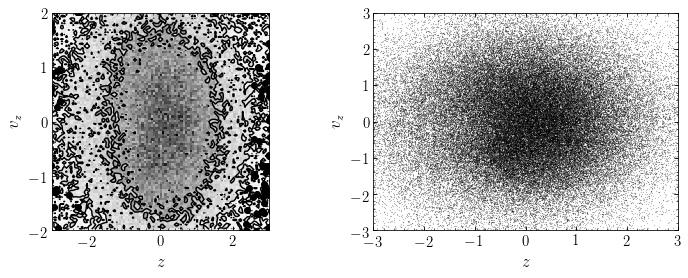

In [16]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.scatterplot(z_mock,vz_mock,'ko',
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-3.0, 3.0],yrange=[-2.0,2.0],gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(z_mock,vz_mock,'ko', 0.1,
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-3.0, 3.0],yrange=[-3.0,3.0],gcf=True, markersize=0.1)


Let's plot the density profile. 

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



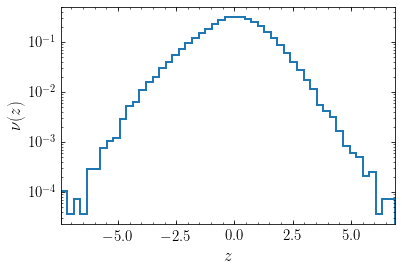

In [17]:
figsize(6,4)
_= bovy_plot.bovy_hist(z_mock,bins=51,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,
                       histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0$ and $X_{nm}=0.1$:

In [29]:
zsun_true= 0.0
xnm_true = 0.1
# We only observe the density at a few z
# z_obs= numpy.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0,
#                    0. -0.2, -0.4, -0.6, -0.8, -1.0, -1.2,
#                    -1.4, -1.6, -1.8, -2.0])
# z_obs= numpy.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
#                    0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 
#                    1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 
#                    1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0,
#                    -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5,
#                    -0.55, -0.6, -0.65, -0.7, -0.75, -0.8, -0.85, -0.9, -0.95, -1.0,
#                    -1.05, -1.1, -1.15, -1.2, -1.25, -1.3, -1.35, -1.4, -1.45, -1.5,
#                    -1.55, -1.6, -1.65, -1.7, -1.75, -1.8, -1.85, -1.9, -1.95, -2.0,])
# z_obs= numpy.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
#                      -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0])
# h_obs= 0.1
# z_obs= numpy.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3,
#                     -0.1, -0.3, -0.5, -0.7, -0.9, -1.1, 1.3])
z_obs= numpy.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9,
                     2.1, 2.3, 2.5, 2.7, 2.9, 3.1,
                    -0.1, -0.3, -0.5, -0.7, -0.9, -1.1, -1.3, -1.5, -1.7, -1.9,
                   -2.1, -2.3, -2.5, -2.7, -2.9, -3.1])
h_obs= 0.2
# z_obs= numpy.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
#                     1.1, 1.2, 1.3, 1.4, 1.5, 
#                    -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0,
#                    -1.1, -1.2, -1.3, -1.4, -1.5])
#h_obs = 0.1
dens_obs= xnm_true*hom2m.compute_dens(z_mock,zsun_true,z_obs,h_obs,w=m_mock)
# dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
#     /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs_noise= 0.01*dens_obs/numpy.sqrt(dens_obs)
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<ErrorbarContainer object of 3 artists>

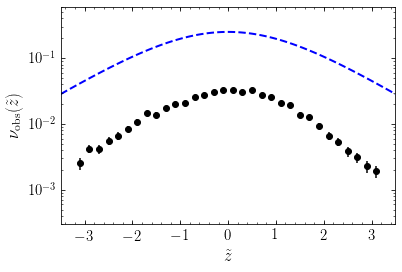

In [30]:
zmin = -3.5
zmax = 3.5
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax], yrange=[xnm_true*0.003, xnm_true*6.])
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [31]:
# We only observe the v2 at a few z (same as before)
v2_obs= hom2m.compute_v2(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
# v2_obs_noise=numpy.zeros_like(v2_obs)+0.002
v2_obs_noise=numpy.zeros_like(v2_obs)+0.01
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise

<ErrorbarContainer object of 3 artists>

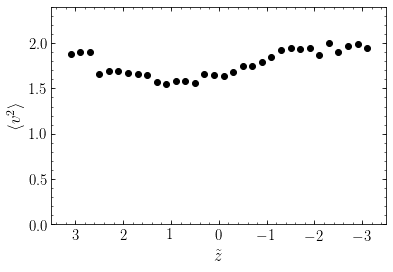

In [32]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[zmax, zmin],yrange=[0.0,2.4],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean velocity:

In [33]:
# We only observe the v2 at a few z (same as before)
v_obs= hom2m.compute_v(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
v_obs_noise=numpy.zeros_like(v_obs)+0.01
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v_obs+= numpy.random.normal(size=v_obs.shape)*v_obs_noise

<ErrorbarContainer object of 3 artists>

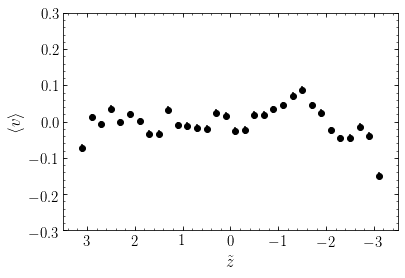

In [34]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v\rangle$',
                   xrange=[zmax, zmin],yrange=[-0.3,0.3],gcf=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color='k')

Now we fit the density profile with $\mathrm{sech}^2$ profile.

fit parameter a, b, c= [3.23748111e-02 7.89881119e-01 4.62785103e-19]


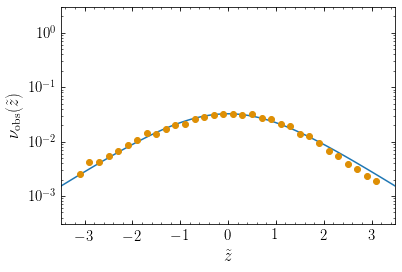

In [35]:
# define sech2 profile
def func_sech2(x, a, b, c):
    return a/(numpy.cosh((x+c)/(2.0*b))**2)
# fit the density with a sech2 profile
popt, pconv = curve_fit(func_sech2, z_obs, dens_obs, bounds=(0, 100))
print('fit parameter a, b, c=', popt)
z_out= numpy.linspace(zmin, zmax, 101)
dens_fit= func_sech2(z_out, *popt)
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_out, dens_fit,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs, dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
yscale('log',nonposy='clip')

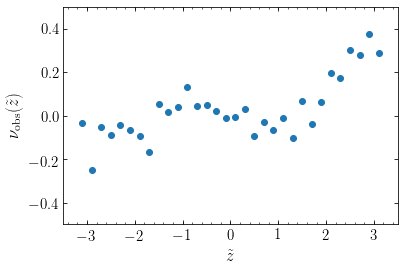

In [36]:
# plot the density differences
dens_fit_obs = func_sech2(z_obs, *popt)
dens_diff = (dens_fit_obs-dens_obs)/dens_obs
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_obs, dens_diff,'o', color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.5, 0.5],gcf=True)
yscale('linear',nonposy='clip')

Let's save the particle data to a file.

In [37]:
# save the unperturbed disk data
# select the final step
with h5py.File('target_disk_perturbed.h5', 'w') as f:
    f.create_dataset('N', data=n_mock)
    f.create_dataset('Mtot', data=totmass_true)
    f.create_dataset('sigma', data=sigma_true)
    f.create_dataset('omega', data=omegadm_true)
    f.create_dataset('z', data=z_mock)
    f.create_dataset('vz', data=vz_mock)
    f.create_dataset('m', data=m_mock)

Let's plot z vs. vz